<a href="https://colab.research.google.com/github/DatalakeLab/Pandas/blob/main/pandas_vs_Numpy_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install py-cpuinfo==5.0.0


     |████████████████████████████████| 82 kB 197 kB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-5.0.0-py3-none-any.whl size=18697 sha256=c95076e63d22ac2ea8f8cdd5e343dda972bd4d1df15a5225f03cc4e5f51eb037
  Stored in directory: /root/.cache/pip/wheels/e7/3b/8e/2b1f0f6cc651cd381bb5806e5005820c6986867c46f3536101
Successfully built py-cpuinfo


In [3]:
import pandas as pd
import numpy as np

import csv
import pickle
import cpuinfo
import timeit

# plotting
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
print("Pandas: {}\n Numpy: {}".format(pd.__version__,np.__version__))


Pandas: 1.1.5
 Numpy: 1.19.5


In [5]:
cpu = cpuinfo.get_cpu_info()
print("Arch: {}\nBrand: {}\nCores: {}".format(cpu['arch'], cpu['brand'], cpu['count']))


Arch: X86_64
Brand: Intel(R) Xeon(R) CPU @ 2.20GHz
Cores: 2


In [18]:
np.random.seed(69)
E = pd.DataFrame(np.random.randn(4, 3), index=['house','rocket','science','Trump'])
print(E)

                0         1         2
house    0.915507 -0.603542  1.162295
rocket  -0.601400 -1.597486  0.397726
science  1.205865  1.056299  0.852544
Trump    0.689391 -0.224737 -0.522182


In [19]:
E.loc['house'] = E.loc['science'] + (0.1 * np.random.randn(1, ))


In [21]:
word = 'science'
w = E.loc[word]
print(w)


0    1.205865
1    1.056299
2    0.852544
Name: science, dtype: float64


In [22]:
dot = E.dot(w.transpose())
norm_u = np.linalg.norm(E, axis=1) 
norm_v = np.linalg.norm(w)
cosine_similarity = dot / (norm_u * norm_v)

In [23]:
print(cosine_similarity)


house      0.999928
rocket    -0.651592
science    1.000000
Trump      0.091678
dtype: float64


In [24]:
cosine_similarity.loc[word] = 0 # little trick to avoid retrieving the word
cosine_similarity.nlargest(1)

house    0.999928
dtype: float64

In [25]:
def dot_prod_benchmark(n, m, num_iters):
    np.random.seed(69)
    E_np = np.random.randn(n, m)
    w_idx = np.random.randint(n)
    w_np = E_np[w_idx]
    np.random.seed(69)
    E_pd = pd.DataFrame(np.random.randn(n, m))
    w_pd = E_pd.iloc[w_idx]
    
    # numpy
    timeit_np = timeit.Timer('E_np.dot(w_np.T)', globals = locals())
    np_time = timeit_np.timeit(number = num_iters) / num_iters * 1000 

    # pandas    
    timeit_pd = timeit.Timer('E_pd.dot(w_pd.transpose())', globals = locals())
    pd_time = timeit_pd.timeit(number = num_iters) / num_iters * 1000
    
    return np_time, pd_time

In [27]:
np_time, pd_time = dot_prod_benchmark(400000, 50, 1000)
print("Numpy time (ms): {}\nPandas time(ms): {}".format(np_time, pd_time))

Numpy time (ms): 21.03909295099993
Pandas time(ms): 29.745693749999646


In [28]:
def full_test(**info):
    saved_file = info.get('saved_file', 'src/data_iter.pickle')
    size_jump = info.get('size_jump', 5000)
    curr_size = info.get('curr_size', size_jump)
    max_size = info.get('max_size', 1000000)
    num_dimensions = info.get('num_dimensions', 50)
    num_iters = info.get('num_iters', 10)
    save_freq = info.get('save_freq', 10)
    sizes_n = range(curr_size, max_size, size_jump)
    sizes_m = [num_dimensions] * len(sizes_n)
    debug = False
    sizes = zip(sizes_n, sizes_m)
    perf_numpy = info.get('perf_numpy', [])
    perf_pandas = info.get('perf_pandas', [])
    for (n, m) in sizes:
        numpy, pandas = dot_prod_benchmark(n, m, num_iters)
        perf_numpy.append(numpy)
        perf_pandas.append(pandas)
        print("Performed on batch of size ({}, {}) with average times: {} ms numpy, {} ms pandas".format(n, m, numpy, pandas))
        if curr_size and curr_size % (save_freq * size_jump) == 0:
            info = {'saved_file': saved_file, 'size_jump': size_jump, 'max_size': max_size, 'num_dimensions': num_dimensions, 
                   'num_iters': num_iters, 'save_freq': save_freq}
            info['perf_numpy'] = perf_numpy
            info['perf_pandas'] = perf_pandas
            info['curr_size'] = curr_size + size_jump
            pickle.dump(info, open(saved_file, "wb" ))
            print("Saving... curr_size = {}".format(info['curr_size']))
        curr_size += size_jump

In [34]:
saved_file = 'sample_data/src/data_iter.pickle'
try:
    info = pickle.load(open(saved_file, "rb"))
except (OSError, IOError) as e:
    info = {
        'save_freq': 5, 
        'num_iters': 1000,
    }
full_test(**info)

Performed on batch of size (980000, 50) with average times: 47.246909487000266 ms numpy, 46.82558818799953 ms pandas
Performed on batch of size (985000, 50) with average times: 46.298194725999565 ms numpy, 46.71246152300046 ms pandas
Performed on batch of size (990000, 50) with average times: 46.50154978199953 ms numpy, 47.40295450500071 ms pandas
Performed on batch of size (995000, 50) with average times: 46.924449033999736 ms numpy, 47.18600130200048 ms pandas


In [69]:
saved_file = 'sample_data/src/data_iter.pickle'
info = pickle.load(open(saved_file, "rb"))

In [70]:
def my_plot(lim_inf, lim_sup, info):
    size_jump = info.get('size_jump')
    assert lim_inf >= size_jump # test starts at size 'size_jump' (so no smaller values). No need to raise exceptions, message to sel
    assert lim_sup % size_jump == 0 # to create consistent xticks
    assert lim_sup > lim_inf # make it explode!
    lim_sup = min(lim_sup, int(info.get('curr_size')))
    inf = max(0, int(lim_inf / size_jump) - 1)
    sup = int(lim_sup / size_jump)
    t_np = info.get('perf_numpy')[inf:sup]
    t_pd = info.get('perf_pandas')[inf:sup]
    xticks = [*range(lim_inf, lim_sup + size_jump, size_jump)]
    t_np = pd.Series(t_np, index=xticks[:len(t_np)])
    t_pd = pd.Series(t_pd, index=xticks[:len(t_pd)])
    fig, ax = plt.subplots()
    fig.set_size_inches(20,10)
    t_np.plot(label='Numpy', rot=90)
    t_pd.plot(label='Pandas', rot=90)
    plt.ylabel('Time (ms)')
    plt.xlabel('Size')
    plt.legend(loc='best')

In [71]:
saved_file = 'sample_data/src/data_iter.pickle'
info = pickle.load(open(saved_file, "rb"))


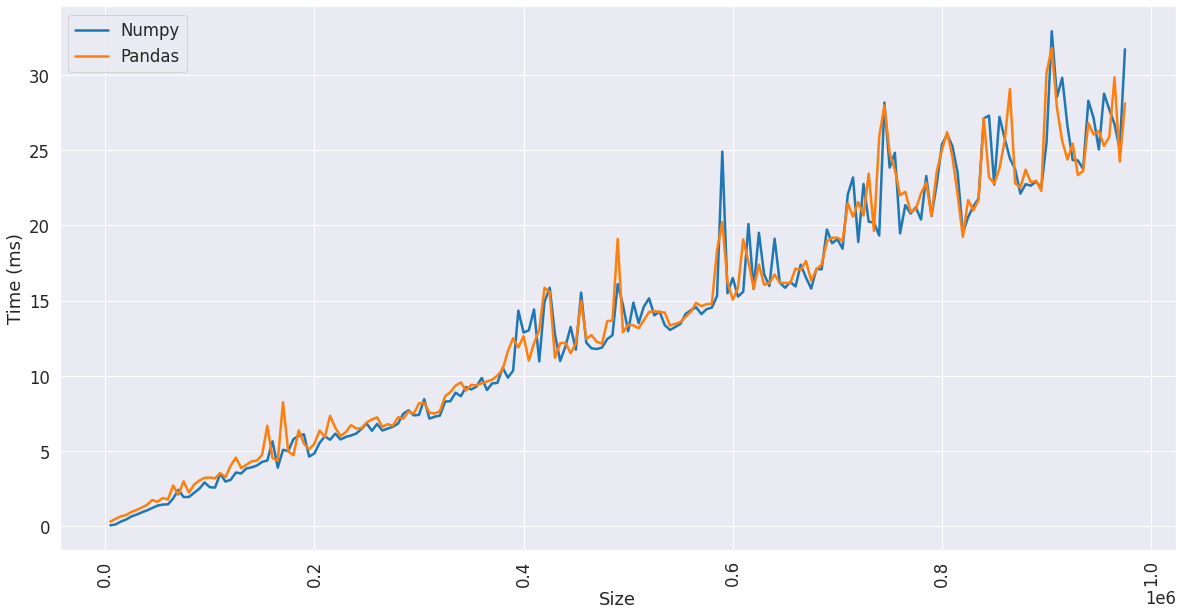

In [72]:
my_plot(5000, 1000000, info)


In [23]:
t_np = info.get('perf_numpy')
t_pd = info.get('perf_pandas')
print("Mean time (ms) numpy: {}\nMean time (ms) pandas: {}".format(np.mean(t_np), np.mean(t_pd)))

Mean time (ms) numpy: 13.640309900584189
Mean time (ms) pandas: 13.764656917930532
